Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as glm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


glm.SET_USE_BIC_LLF = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_film_tv_movies = pd.read_csv("INPUT/filmtv_movies.csv")

# Remove duplicates based on 'title'
df_film_tv_movies = df_film_tv_movies.drop_duplicates(subset='title')

## Target Definition

Predict the critique ratings, then transform it to rotten tomatoes ratings:
- Certified Fresh (Score: 8+)
- Fresh (Score: 6-8)
- Rotten (Score: <6)

## Function List

In [3]:
# Define Certified Fresh, Fresh, and Rotten
def determine_tomato_status(row):
    if row['critics_vote'] >= 8:
        return 'Certified Fresh'
    elif row['critics_vote'] >= 6:
        return 'Fresh'
    else:
        return 'Rotten'



def model_summary(model_1, model_2, model_name, feature_name, conclusion, reason, summary_df=None): 
    """
    Appends the summary of a GLM or OLS model to a DataFrame with the RMSE difference compared to a benchmark model.

    Parameters:
    - model_1: The current fitted GLM or OLS model.
    - model_2: The benchmark GLM or OLS model.
    - model_name: A string representing the name of the model (e.g., 'GLM 0').
    - feature_name: A string that contains the selection of features.
    - conclusion: Model selection conclusion (accept or reject).
    - reason: Reason for the conclusion.
    - summary_df: An existing DataFrame to append to (default: None, creates a new one).

    Returns:
    - A DataFrame containing the model summaries.
    """

    def calculate_rmse(model):
        """
        Calculate RMSE for GLM or OLS model.

        Parameters:
        - model: The fitted model.

        Returns:
        - RMSE value.
        """
        if hasattr(model, 'resid_response'):
            # GLM model
            residuals = model.resid_response
        elif hasattr(model, 'resid'):
            # OLS model
            residuals = model.resid
        else:
            raise ValueError("Model does not have residuals attribute for RMSE calculation.")
        return np.sqrt(np.mean(residuals**2))

    # Calculate RMSE for both models
    current_rmse = calculate_rmse(model_1)
    benchmark_rmse = calculate_rmse(model_2)
    
    # Compute RMSE differences
    rmse_diff = current_rmse - benchmark_rmse
    rmse_diff_pc = None
    if benchmark_rmse != 0:
        rmse_diff_pc = (rmse_diff / benchmark_rmse) * 100

    rmse_diff_pc_str = f"{rmse_diff_pc:.2f}%" if rmse_diff_pc is not None else None

    # Extract metrics
    model_metrics = {
        "Model": model_name,
        "Feature": feature_name,
        "AIC": model_1.aic,
        "BIC": model_1.bic,
        "RMSE": current_rmse,
        "ΔRMSE": rmse_diff,
        "ΔRMSE%": rmse_diff_pc_str,
        "Conclusion": conclusion,
        "Reason": reason
    }

    # Initialize or update the summary DataFrame
    if summary_df is None:
        summary_df = pd.DataFrame(columns=["Model", "Feature", "AIC", "BIC", "RMSE", "ΔRMSE", "ΔRMSE%", "Conclusion", "Reason"])

    # Append the new model metrics to the summary DataFrame
    summary_df = pd.concat([summary_df, pd.DataFrame([model_metrics])], ignore_index=True)

    return summary_df


def cross_validate_glm(formula, data, family, k=5):
    """
    Perform k-fold cross-validation for a GLM model.
    
    Parameters:
    - formula: The formula for the GLM model.
    - data: The dataset to use for cross-validation.
    - family: The family for the GLM (e.g., sm.families.Gaussian()).
    - k: The number of folds for cross-validation (default: 5).
    
    Returns:
    - A dictionary with mean RMSE, individual RMSEs, and fitted models for each fold.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    rmse_scores = []
    fold_models = []
    
    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # Fit the GLM model on training data
        model = sm.GLM.from_formula(formula, data=train_data, family=family).fit()
        
        # Predict on the test data
        predictions = model.predict(test_data)
        
        # Calculate RMSE for the fold
        fold_rmse = np.sqrt(mean_squared_error(test_data['critics_vote'], predictions))
        rmse_scores.append(fold_rmse)
        fold_models.append(model)
    
    # Return mean RMSE, all RMSEs, and the models
    return {
        "mean_rmse": np.mean(rmse_scores),
        "rmse_scores": rmse_scores,
        "models": fold_models
    }


## Initial Feature Selection

In [4]:
df_film = df_film_tv_movies.copy()
df_film = df_film.drop(columns=['description', 'notes', 'filmtv_id', 'title'])

## Imputation

### Linear Model Imputation

#### Correlation Analysis

In [5]:
vote_variable_set = ['avg_vote', 'public_vote', 'total_votes', 'critics_vote']
df_vote = df_film[vote_variable_set]
vote_corr_matrix = df_vote.corr()

print("Correlation matrix:")
print(vote_corr_matrix)

Correlation matrix:
              avg_vote  public_vote  total_votes  critics_vote
avg_vote      1.000000     0.893057     0.256838      0.916147
public_vote   0.893057     1.000000     0.214977      0.622646
total_votes   0.256838     0.214977     1.000000      0.238559
critics_vote  0.916147     0.622646     0.238559      1.000000


#### Critics Vote

In [6]:
# Prepare data for critics_vote
non_missing_critics_vote = df_film[df_film['critics_vote'].notnull()]
missing_critics_vote = df_film[df_film['critics_vote'].isnull()]

X_critics_vote = non_missing_critics_vote[['avg_vote', 'public_vote', 'total_votes']].dropna()  # Features
y_critics_vote = non_missing_critics_vote.loc[X_critics_vote.index, 'critics_vote']  # Target

# Drop NaNs in X_missing_critics_vote
X_missing_critics_vote = missing_critics_vote[['avg_vote', 'public_vote', 'total_votes']].dropna()

# Train model
model_critics_vote = LinearRegression()
model_critics_vote.fit(X_critics_vote, y_critics_vote)

# Predict missing values
df_film.loc[X_missing_critics_vote.index, 'critics_vote'] = model_critics_vote.predict(X_missing_critics_vote)

#### Public Vote

In [7]:
# Prepare data for public_vote
non_missing_public_vote = df_film[df_film['public_vote'].notnull()]
missing_public_vote = df_film[df_film['public_vote'].isnull()]

X_public_vote = non_missing_public_vote[['avg_vote', 'critics_vote', 'total_votes']].dropna()  # Features
y_public_vote = non_missing_public_vote.loc[X_public_vote.index, 'public_vote']  # Target

# Drop NaNs in X_missing_public_vote
X_missing_public_vote = missing_public_vote[['avg_vote', 'critics_vote', 'total_votes']].dropna()

# Train model
model_public_vote = LinearRegression()
model_public_vote.fit(X_public_vote, y_public_vote)

# Predict missing values
df_film.loc[X_missing_public_vote.index, 'public_vote'] = model_public_vote.predict(X_missing_public_vote)

## Simple Imputation

#### Actors, Directors, Genre, Country

In [8]:
df_film['actors'] = df_film['actors'].fillna('Unknown')

### Directors

In [9]:
df_film['directors'] = df_film['directors'].fillna('Unknown')

### Genre

In [10]:
df_film['genre'] = df_film['genre'].fillna('Unknown')

### Country

In [11]:
df_film['country'] = df_film['country'].fillna('Unknown')

## Train-Test Split

In [12]:
X = df_film.drop(columns='critics_vote')  # Features
y = df_film['critics_vote']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

## Data Analysis

### Data Explosion

In [13]:
# Reset the index to ensure consistency
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

#### Actors

In [14]:
# Split actors into a list
train_data['actors_list'] = train_data['actors'].apply(lambda x: str(x).split(', '))

# Explode the actors_list into individual rows
df_actors_exploded = train_data.explode('actors_list')

# Group by actor and calculate number of appearances and average critics_vote
actor_stats = df_actors_exploded.groupby('actors_list').agg(
    num_appearances=('actors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
actor_stats = actor_stats.sort_values(by='num_appearances', ascending=False)

In [15]:
# Split actors into a list
test_data['actors_list'] = test_data['actors'].apply(lambda x: str(x).split(', '))

# Explode the actors_list into individual rows
df_actors_exploded_test = test_data.explode('actors_list')

# Group by actor and calculate number of appearances and average critics_vote
actor_stats_test = df_actors_exploded_test.groupby('actors_list').agg(
    num_appearances=('actors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
actor_stats_test = actor_stats_test.sort_values(by='num_appearances', ascending=False)

#### Directors

In [16]:
# Split directors into a list
train_data['directors_list'] = train_data['directors'].apply(lambda x: str(x).split(', '))

# Explode the directors_list into individual rows
df_directors_exploded = train_data.explode('directors_list')

# Group by director and calculate number of appearances and average critics_vote
director_stats = df_directors_exploded.groupby('directors_list').agg(
    num_appearances=('directors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
director_stats = director_stats.sort_values(by='num_appearances', ascending=False)


In [17]:
# Split directors into a list
test_data['directors_list'] = test_data['directors'].apply(lambda x: str(x).split(', '))

# Explode the directors_list into individual rows
df_directors_exploded_test = test_data.explode('directors_list')

# Group by director and calculate number of appearances and average critics_vote
director_stats_test = df_directors_exploded_test.groupby('directors_list').agg(
    num_appearances=('directors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
director_stats_test = director_stats_test.sort_values(by='num_appearances', ascending=False)


#### Country

In [18]:
# Split countries into a list
train_data['countries_list'] = train_data['country'].apply(lambda x: str(x).split(', '))

# Explode the countries_list into individual rows
df_countries_exploded = train_data.explode('countries_list')

# Group by country and calculate number of appearances and average critics_vote
country_stats = df_countries_exploded.groupby('countries_list').agg(
    num_appearances=('countries_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
country_stats = country_stats.sort_values(by='num_appearances', ascending=False)


In [19]:
# Split countries into a list
test_data['countries_list'] = test_data['country'].apply(lambda x: str(x).split(', '))

# Explode the countries_list into individual rows
df_countries_exploded_test = test_data.explode('countries_list')

# Group by country and calculate number of appearances and average critics_vote
country_stats_test = df_countries_exploded_test.groupby('countries_list').agg(
    num_appearances=('countries_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
country_stats_test = country_stats_test.sort_values(by='num_appearances', ascending=False)


#### Genre

In [20]:
# Split genres into a list
train_data['genres_list'] = train_data['genre'].apply(lambda x: str(x).split(', '))

# Explode the genres_list into individual rows
df_genres_exploded = train_data.explode('genres_list')

# Group by genre and calculate number of appearances and average critics_vote
genre_stats = df_genres_exploded.groupby('genres_list').agg(
    num_appearances=('genres_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
genre_stats = genre_stats.sort_values(by='num_appearances', ascending=False)


In [21]:
# Split genres into a list
test_data['genres_list'] = test_data['genre'].apply(lambda x: str(x).split(', '))

# Explode the genres_list into individual rows
df_genres_exploded_test = test_data.explode('genres_list')

# Group by genre and calculate number of appearances and average critics_vote
genre_stats_test = df_genres_exploded_test.groupby('genres_list').agg(
    num_appearances=('genres_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Sort by number of appearances
genre_stats_test = genre_stats_test.sort_values(by='num_appearances', ascending=False)

### Representation Analysis

#### Country

In [22]:
# Add representation percentage and cumulative percentage (train)
total_appearances = country_stats['num_appearances'].sum()
country_stats['representation'] = (country_stats['num_appearances'] / total_appearances) * 100
country_stats['cumulative_percentage'] = country_stats['representation'].cumsum()

#### Genres

In [23]:
# Add representation percentage and cumulative percentage
total_appearances = genre_stats['num_appearances'].sum()
genre_stats['representation'] = (genre_stats['num_appearances'] / total_appearances) * 100
genre_stats['cumulative_percentage'] = genre_stats['representation'].cumsum()

## Feature Engineering

### Statistical Features

#### Actors

In [24]:
# Split actors into a list
df_film['actors_list'] = df_film['actors'].apply(lambda x: str(x).split(', '))

# Explode the actors_list into individual rows
df_actors_exploded_film = df_film.explode('actors_list')

# Group by actor and calculate number of appearances and average critics_vote
actor_stats = df_actors_exploded_film.groupby('actors_list').agg(
    num_appearances=('actors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Create dictionaries
actor_frequency_dict = actor_stats.set_index('actors_list')['num_appearances'].to_dict()
actor_avg_vote_dict = actor_stats.set_index('actors_list')['avg_critics_vote'].to_dict()

In [25]:
# Add frequency and average critics vote to exploded DataFrame
df_actors_exploded['actor_frequency'] = df_actors_exploded['actors_list'].map(actor_frequency_dict)
df_actors_exploded['actor_avg_critics_vote'] = df_actors_exploded['actors_list'].map(actor_avg_vote_dict)

# Aggregate statistics back to the original DataFrame
df_actors_aggregated = df_actors_exploded.groupby(df_actors_exploded.index).agg(
    actor_frequency=('actor_frequency', 'mean'),
    actor_avg_critics_vote=('actor_avg_critics_vote', 'mean')
).reset_index()

# Merge aggregated data back to the original DataFrame
train_data = train_data.merge(df_actors_aggregated, left_index=True, right_on='index', how='left').drop(columns='index')

In [26]:
# Add frequency and average critics vote to exploded DataFrame plus error handling
df_actors_exploded_test['actor_frequency'] = df_actors_exploded_test['actors_list'].map(actor_frequency_dict).fillna(0)
df_actors_exploded_test['actor_avg_critics_vote'] = df_actors_exploded_test['actors_list'].map(actor_avg_vote_dict).fillna(train_data['actor_avg_critics_vote'].mean())

# Aggregate statistics back to the original DataFrame
df_actors_aggregated_test = df_actors_exploded_test.groupby(df_actors_exploded_test.index).agg(
    actor_frequency=('actor_frequency', 'mean'),
    actor_avg_critics_vote=('actor_avg_critics_vote', 'mean')
).reset_index()

# Merge aggregated data back to the original DataFrame
test_data = test_data.merge(df_actors_aggregated_test, left_index=True, right_on='index', how='left').drop(columns='index')

#### Directors

In [27]:
# Split directors into a list for df_film
df_film['directors_list'] = df_film['directors'].apply(lambda x: str(x).split(', '))

# Explode the directors_list into individual rows
df_directors_exploded_film = df_film.explode('directors_list')

# Group by director and calculate number of appearances and average critics_vote
director_stats_film = df_directors_exploded_film.groupby('directors_list').agg(
    num_appearances=('directors_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Create dictionaries
director_frequency_dict = director_stats_film.set_index('directors_list')['num_appearances'].to_dict()
director_avg_vote_dict = director_stats_film.set_index('directors_list')['avg_critics_vote'].to_dict()

In [28]:
# Add frequency and average critics vote to exploded DataFrame
df_directors_exploded['director_frequency'] = df_directors_exploded['directors_list'].map(director_frequency_dict)
df_directors_exploded['director_avg_critics_vote'] = df_directors_exploded['directors_list'].map(director_avg_vote_dict)

# Aggregate statistics back to the original DataFrame
df_directors_aggregated = df_directors_exploded.groupby(df_directors_exploded.index).agg(
    director_frequency=('director_frequency', 'mean'),
    director_avg_critics_vote=('director_avg_critics_vote', 'mean')
).reset_index()

# Merge aggregated data back to the original DataFrame
train_data = train_data.merge(df_directors_aggregated , left_index=True, right_on='index', how='left').drop(columns='index')

In [29]:
# Add frequency and average critics vote to exploded DataFrame plus error handling
df_directors_exploded_test['director_frequency'] = df_directors_exploded_test['directors_list'].map(director_frequency_dict).fillna(0)
df_directors_exploded_test['director_avg_critics_vote'] = df_directors_exploded_test['directors_list'].map(director_avg_vote_dict).fillna(train_data['director_avg_critics_vote'].mean())

# Aggregate statistics back to the original DataFrame
df_directors_aggregated_test = df_directors_exploded_test.groupby(df_directors_exploded_test.index).agg(
    director_frequency=('director_frequency', 'mean'),
    director_avg_critics_vote=('director_avg_critics_vote', 'mean')
).reset_index()

# Merge aggregated data back to the original DataFrame
test_data = test_data.merge(df_directors_aggregated_test , left_index=True, right_on='index', how='left').drop(columns='index')

#### Genre

In [30]:
# Split genres into a list
df_film['genres_list'] = df_film['genre'].apply(lambda x: str(x).split(', '))

# Explode the genres_list into individual rows
df_genres_exploded_film = df_film.explode('genres_list')

# Group by genre and calculate number of appearances and average critics_vote
genre_stats = df_genres_exploded_film.groupby('genres_list').agg(
    num_appearances=('genres_list', 'size'),
    avg_critics_vote=('critics_vote', 'mean')
).reset_index()

# Create dictionaries
genre_frequency_dict = genre_stats.set_index('genres_list')['num_appearances'].to_dict()
genre_avg_vote_dict = genre_stats.set_index('genres_list')['avg_critics_vote'].to_dict()

In [31]:
# Add frequency and average critics vote to exploded DataFrame
df_genres_exploded['genre_frequency'] = df_genres_exploded['genres_list'].map(genre_frequency_dict)
df_genres_exploded['genre_avg_critics_vote'] = df_genres_exploded['genres_list'].map(genre_avg_vote_dict)

# Aggregate statistics back to the original DataFrame
df_genres_aggregated = df_genres_exploded.groupby(level=0).agg(
    genre_frequency=('genre_frequency', 'mean'),
    genre_avg_critics_vote=('genre_avg_critics_vote', 'mean')
).reset_index()

# Ensure there are no conflicting column names during merge
df_genres_aggregated = df_genres_aggregated.rename(columns={'index': 'original_index'})

# Merge aggregated data back to the original DataFrame
train_data = train_data.merge(df_genres_aggregated, left_index=True, right_on='original_index', how='left')

# Drop the temporary merge key
train_data = train_data.drop(columns=['original_index'])

In [32]:
# Add frequency and average critics vote to exploded DataFrame plus error handling
df_genres_exploded_test['genre_frequency'] = df_genres_exploded_test['genres_list'].map(genre_frequency_dict).fillna(0)
df_genres_exploded_test['genre_avg_critics_vote'] = df_genres_exploded_test['genres_list'].map(genre_avg_vote_dict).fillna(train_data['genre_avg_critics_vote'].mean())

# Aggregate statistics back to the original DataFrame
df_genres_aggregated_test = df_genres_exploded_test.groupby(level=0).agg(
    genre_frequency=('genre_frequency', 'mean'),
    genre_avg_critics_vote=('genre_avg_critics_vote', 'mean')
).reset_index()

# Ensure there are no conflicting column names during merge
df_genres_aggregated_test = df_genres_aggregated_test.rename(columns={'index': 'original_index'})

# Merge aggregated data back to the original DataFrame
test_data = test_data.merge(df_genres_aggregated_test, left_index=True, right_on='original_index', how='left')

# Drop the temporary merge key
test_data = test_data.drop(columns=['original_index'])


In [33]:
#### Country
# Create dictionaries
country_frequency_dict = country_stats.set_index('countries_list')['num_appearances'].to_dict()
country_avg_vote_dict = country_stats.set_index('countries_list')['avg_critics_vote'].to_dict()

# Add frequency and average critics vote to exploded DataFrame
df_countries_exploded['country_frequency'] = df_countries_exploded['countries_list'].map(country_frequency_dict)
df_countries_exploded['country_avg_critics_vote'] = df_countries_exploded['countries_list'].map(country_avg_vote_dict)

# Aggregate statistics back to the original DataFrame
df_film_aggregated = df_countries_exploded.groupby(level=0).agg(
    country_frequency=('country_frequency', 'mean'),
    country_avg_critics_vote=('country_avg_critics_vote', 'mean')
).reset_index()

# Ensure there are no conflicting column names during merge
df_film_aggregated = df_film_aggregated.rename(columns={'index': 'original_index'})

# Merge aggregated data back to the original DataFrame
train_data = train_data.merge(df_film_aggregated, left_index=True, right_on='original_index', how='left')

# Drop the temporary merge key
train_data = train_data.drop(columns=['original_index'])
# Add frequency and average critics vote to exploded DataFrame plus error handling
df_countries_exploded_test['country_frequency'] = df_countries_exploded_test['countries_list'].map(country_frequency_dict).fillna(0)
df_countries_exploded_test['country_avg_critics_vote'] = df_countries_exploded_test['countries_list'].map(country_avg_vote_dict).fillna(train_data['country_avg_critics_vote'].mean())

# Aggregate statistics back to the original DataFrame
df_film_aggregated_test = df_countries_exploded_test.groupby(level=0).agg(
    country_frequency=('country_frequency', 'mean'),
    country_avg_critics_vote=('country_avg_critics_vote', 'mean')
).reset_index()

# Ensure there are no conflicting column names during merge
df_film_aggregated_test = df_film_aggregated_test.rename(columns={'index': 'original_index'})

# Merge aggregated data back to the original DataFrame
test_data = test_data.merge(df_film_aggregated_test, left_index=True, right_on='original_index', how='left')

# Drop the temporary merge key
test_data = test_data.drop(columns=['original_index'])

### Missingness Indicators

These features created to support the 'unknown' missing data:
- IS_ACTOR_MISSING
- IS_GENRE_MISSING
- IS_COUNTRY_MISSING
- IS_DIRECTOR_MISING

These missingness indicators intended to:
- Preserve interpretability
- Prevent imputation bias
- Reduce potential noise

In [34]:
# Create binary flags for missing data
train_data['IS_ACTOR_MISSING'] = train_data['actors'].apply(lambda x: int(x == 'Unknown'))
train_data['IS_GENRE_MISSING'] = train_data['genre'].apply(lambda x: int(x == 'Unknown'))
train_data['IS_COUNTRY_MISSING'] = train_data['country'].apply(lambda x: int(x == 'Unknown'))
train_data['IS_DIRECTOR_MISSING'] = train_data['directors'].apply(lambda x: int(x == 'Unknown'))

test_data['IS_ACTOR_MISSING'] = test_data['actors'].apply(lambda x: int(x == 'Unknown'))
test_data['IS_GENRE_MISSING'] = test_data['genre'].apply(lambda x: int(x == 'Unknown'))
test_data['IS_COUNTRY_MISSING'] = test_data['country'].apply(lambda x: int(x == 'Unknown'))
test_data['IS_DIRECTOR_MISSING'] = test_data['directors'].apply(lambda x: int(x == 'Unknown'))


# Display the DataFrame to verify
print(train_data[['IS_ACTOR_MISSING', 'IS_GENRE_MISSING', 'IS_COUNTRY_MISSING', 'IS_DIRECTOR_MISSING']].head())


   IS_ACTOR_MISSING  IS_GENRE_MISSING  IS_COUNTRY_MISSING  IS_DIRECTOR_MISSING
0                 0                 0                   0                    0
1                 0                 0                   0                    0
2                 0                 0                   0                    0
3                 0                 0                   0                    0
4                 0                 0                   0                    0


### Feature Isolation

Based on representation analysis on country_stats and genre_stats, candidate for feature isolation are as follows:
- Top 8 Country
- Top 16 Genres

These feature isolation intended to:
- Reduce model dimension for GLM
- Reduce potential for overfitting
- Feature prioritization

##### Country Isolation

In [35]:
# Identify the top 8 countries
top_countries = country_stats['countries_list'].head(8).tolist()

# Create IS_POPULAR_COUNTRY feature
train_data['IS_POPULAR_COUNTRY'] = train_data['countries_list'].apply(
    lambda countries: int(any(country in top_countries for country in countries))
)

test_data['IS_POPULAR_COUNTRY'] = test_data['countries_list'].apply(
    lambda countries: int(any(country in top_countries for country in countries))
)

##### Genre Isolation

In [36]:
# Identify the top 10 genres
top_genres = genre_stats['genres_list'].head(10).tolist()

# Create IS_POPULAR_GENRE feature
train_data['IS_POPULAR_GENRE'] = train_data['genre'].apply(
    lambda x: int(x in top_genres)
)

test_data['IS_POPULAR_GENRE'] = test_data['genre'].apply(
    lambda x: int(x in top_genres)
)

### Multicollinearity Testing

Based on the multicollinearity testing, there is no significant correlation between the features.

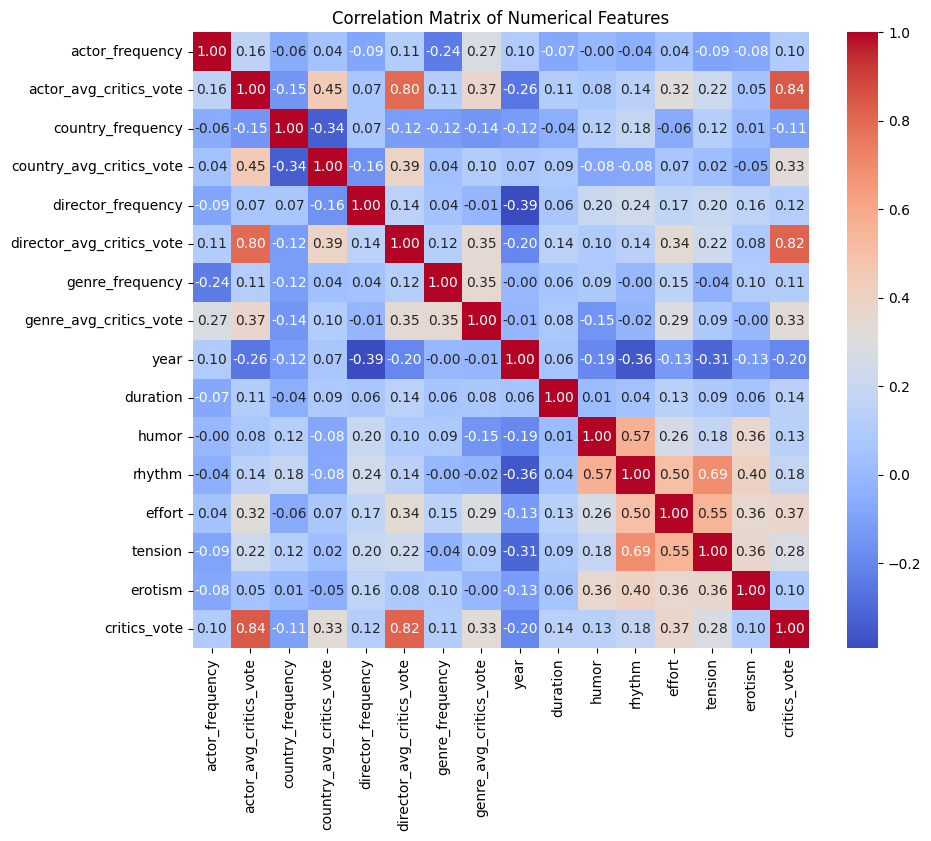

                           actor_frequency  actor_avg_critics_vote  \
actor_frequency                   1.000000                0.155249   
actor_avg_critics_vote            0.155249                1.000000   
country_frequency                -0.055778               -0.146523   
country_avg_critics_vote          0.043721                0.450043   
director_frequency               -0.087421                0.068507   
director_avg_critics_vote         0.106500                0.803373   
genre_frequency                  -0.240238                0.114315   
genre_avg_critics_vote            0.271189                0.370651   
year                              0.097462               -0.255036   
duration                         -0.073572                0.109268   
humor                            -0.002779                0.075652   
rhythm                           -0.039392                0.136209   
effort                            0.043854                0.316288   
tension             

In [37]:
# Select numerical features for correlation analysis
predictor_features = ['actor_frequency', 'actor_avg_critics_vote',
                      'country_frequency', 'country_avg_critics_vote',
                      'director_frequency', 'director_avg_critics_vote',
                      'genre_frequency', 'genre_avg_critics_vote',
                      'year', 'duration', 'humor', 'rhythm', 'effort',
                      'tension', 'erotism', 'critics_vote']

# Drop features not in the dataset
numerical_features = [col for col in predictor_features if col in train_data.columns]

# Calculate the correlation matrix
correlation_matrix = train_data[predictor_features].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Print correlation matrix
print(correlation_matrix)

### Train-test Consistency

It appears that the newly generated features are consistent between the train-test set based on the distribution below.

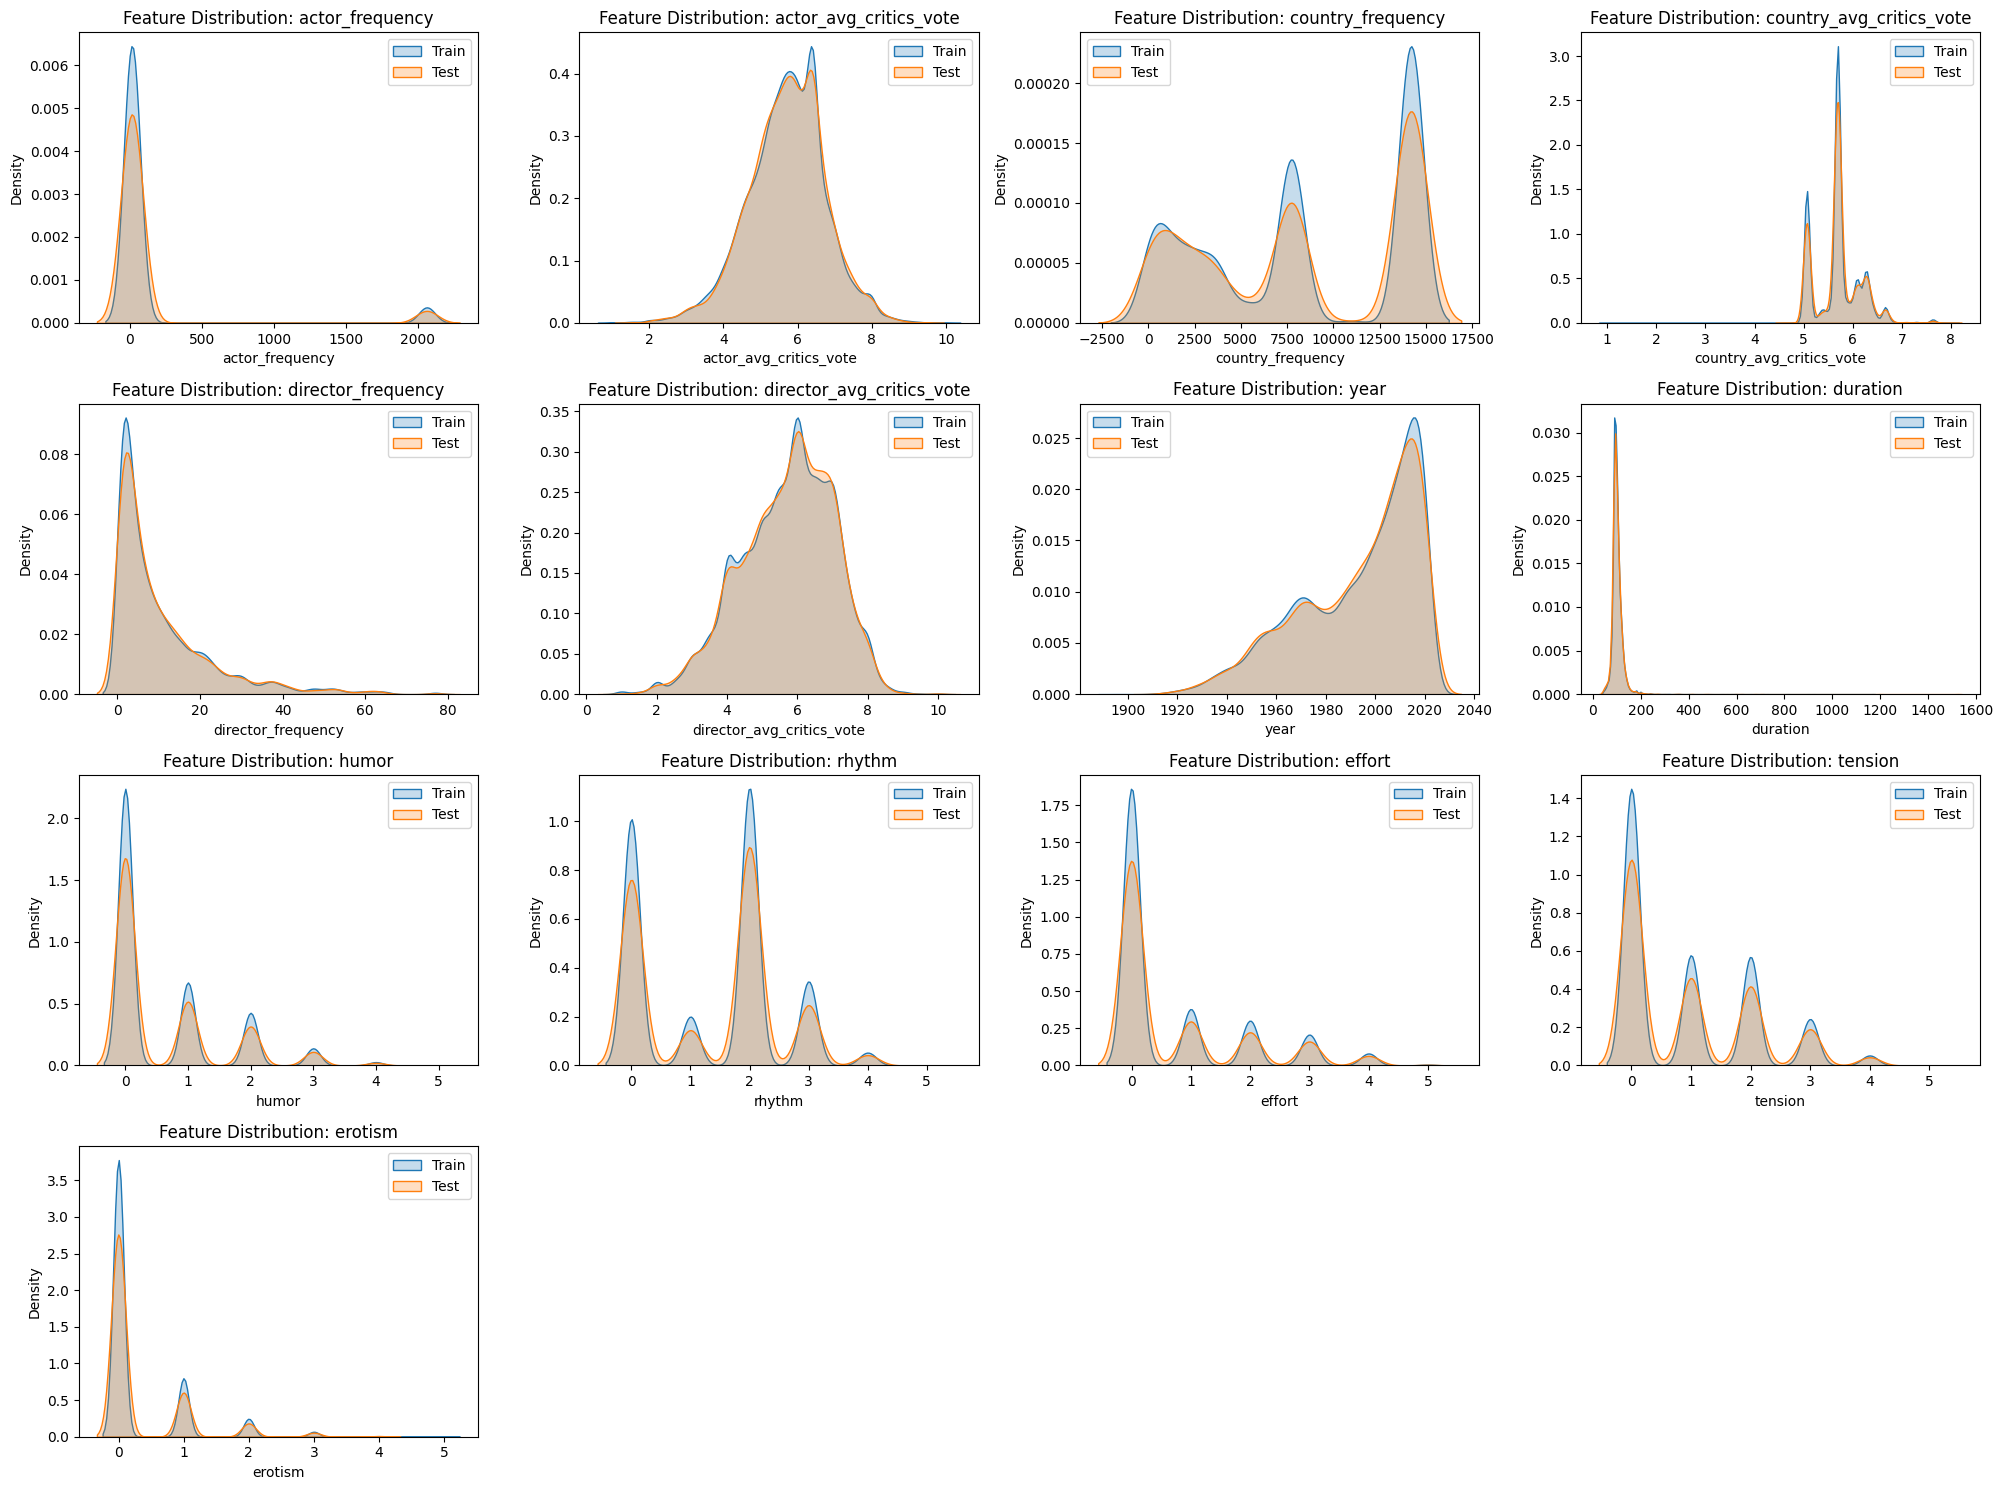

In [38]:
feature_columns = ['actor_frequency', 'actor_avg_critics_vote',
                      'country_frequency', 'country_avg_critics_vote',
                      'director_frequency', 'director_avg_critics_vote',
                      'year', 'duration', 'humor', 'rhythm', 'effort',
                      'tension', 'erotism']

num_features = len(feature_columns)
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(20, 15))

for i, col in enumerate(feature_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.kdeplot(train_data[col], label="Train", shade=True)
    sns.kdeplot(test_data[col], label="Test", shade=True)
    plt.title(f"Feature Distribution: {col}")
    plt.legend()

plt.tight_layout()
plt.show()

## Model Selection

### Managing Multicollinearity
Based on the multicollinearity testing: humor, rythm, effort, tension, and erotism has high correlation which indicates potential redudancy. actor_avg_critics_vote and director_avg_critics_vote also appear to have high correlation. Further testing is done as part of model selection to manage those variables.

#### F-Test (Univariate Regression)

F-test comparing the variances between multiple features.

In [39]:
# Select features and target
X = train_data[['humor', 'rhythm', 'effort', 'tension', 'erotism']]
y = train_data['critics_vote']

# Perform F-Test
f_values, p_values = f_regression(X, y)

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
feature_importance = feature_importance.sort_values(by='F-Value', ascending=False)

print(feature_importance)


   Feature      F-Value        P-Value
2   effort  5148.336532   0.000000e+00
3  tension  2688.613373   0.000000e+00
1   rhythm  1080.418327  5.024353e-233
0    humor   556.102687  6.694558e-122
4  erotism   288.646802   1.895468e-64


In [40]:
# Select features and target
X = train_data[['actor_avg_critics_vote', 'director_avg_critics_vote']]
y = train_data['critics_vote']

# Perform F-Test
f_values, p_values = f_regression(X, y)

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
feature_importance = feature_importance.sort_values(by='F-Value', ascending=False)

print(feature_importance)


                     Feature       F-Value  P-Value
0     actor_avg_critics_vote  76387.248471      0.0
1  director_avg_critics_vote  64820.182536      0.0


The results indicate that all five selected features (effort, tension, rhythm, humor, and erotism) and two new features (actor_avg_critics_vote and director_avg_critics_vote) are highly predictive of critics_vote, as shown by their substantial F-values and extremely low P-values. However, the presence of moderate correlations among these features suggests potential multicollinearity, which can affect the stability and interpretability of GLM model.

#### VIF Test (Variance Inflation Factor)

VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity.

In [41]:
# Select the predictors
selected_features = ['effort', 'tension', 'rhythm', 'humor', 'erotism']
X = train_data[selected_features]

# Add a constant for intercept
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


   Feature       VIF
0    const  2.382253
1   effort  1.534998
2  tension  2.555483
3   rhythm  3.214208
4    humor  1.816784
5  erotism  1.314497


In [42]:
# Select the predictors
selected_features = ['actor_avg_critics_vote', 'director_avg_critics_vote']
X = train_data[selected_features]

# Add a constant for intercept
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                     Feature        VIF
0                      const  30.888861
1     actor_avg_critics_vote   2.820145
2  director_avg_critics_vote   2.820145


Interpretation:

VIF < 5: Generally acceptable.  
5 ≤ VIF < 10: Indicates moderate multicollinearity.  
VIF ≥ 10: Indicates high multicollinearity, which is problematic.  

Based on the VIF test above, those variables are not having significant multicollinearity.

### Statistical Feature Selection

#### P-test (Significance Test)

Significance test is done to select only significant features to improve interpretability and maximizing performance if applicable.

In [43]:
feature_columns = ['actor_frequency', 'actor_avg_critics_vote',
                      'country_frequency', 'country_avg_critics_vote',
                      'director_frequency', 'director_avg_critics_vote',
                      'year', 'duration', 'humor', 'rhythm', 'effort',
                      'tension', 'erotism', 'IS_GENRE_MISSING',
                      'IS_COUNTRY_MISSING', 'IS_DIRECTOR_MISSING',
                      'IS_POPULAR_COUNTRY', 'IS_POPULAR_GENRE']

X = train_data[feature_columns]
y = train_data['critics_vote']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           critics_vote   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     6333.
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:27:10   Log-Likelihood:                -35822.
No. Observations:               31624   AIC:                         7.168e+04
Df Residuals:                   31605   BIC:                         7.184e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Based on the p-test above, it is shown that missingness indicators are not statistically significant. Thus, we can remove those to simplify the model. This is expected due to small amount of missingness and it might be completely random (MCAR), thus keeping this indicators didn't add value to the model.
- IS_ACTOR_MISSING
- IS_GENRE_MISSING
- IS_COUNTRY_MISSING
- IS_DIRECTOR_MISING

In [44]:
feature_columns = ['actor_frequency', 'actor_avg_critics_vote',
                      'country_frequency', 'country_avg_critics_vote',
                      'director_frequency', 'director_avg_critics_vote',
                      'year', 'duration', 'humor', 'rhythm', 'effort',
                      'tension', 'erotism']

X = train_data[feature_columns]
y = train_data['critics_vote']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           critics_vote   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     8748.
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:27:10   Log-Likelihood:                -35853.
No. Observations:               31624   AIC:                         7.173e+04
Df Residuals:                   31610   BIC:                         7.185e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### VIF Test (Variance Inflation Factor)

In [45]:
# Add constant
X_const = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame({
    'Feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

print(vif_data)

                      Feature           VIF
0                       const  10908.827182
1             actor_frequency      1.084843
2      actor_avg_critics_vote      3.304530
3           country_frequency      1.206581
4    country_avg_critics_vote      1.494232
5          director_frequency      1.289129
6   director_avg_critics_vote      2.992188
7                        year      1.480428
8                    duration      1.058840
9                       humor      1.849237
10                     rhythm      3.395656
11                     effort      1.770615
12                    tension      2.677732
13                    erotism      1.340190


Based on the VIF Test above, we retain all candidate predictor variables since the VIF are below 5.

In [46]:
# Calculate residuals from the OLS model
residuals = model.resid

# Add residuals to the DataFrame for analysis
train_data['residuals'] = residuals

# Display the first few rows to verify
print(train_data[['critics_vote', 'residuals']].head())


   critics_vote  residuals
0      5.374737  -0.428782
1      5.000000  -0.588702
2      6.000000  -0.745387
3      8.000000   1.294836
4      7.480000  -0.299478


### Forward Selection

#### GLM 0: Intercept Only

In [47]:
# Intercept-Only OLS Model
glm_0 = sm.GLM.from_formula(
    'critics_vote ~ 1',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

# Display the summary
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries

print(glm_0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           critics_vote   No. Observations:                31624
Model:                            GLM   Df Residuals:                    31623
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          2.5990
Method:                          IRLS   Log-Likelihood:                -59975.
Date:                Tue, 10 Dec 2024   Deviance:                       82189.
Time:                        14:27:10   Pearson chi2:                 8.22e+04
No. Iterations:                     3   Pseudo R-squ. (CS):          5.000e-10
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7111      0.009    629.980      0.0

#### GLM 1: actor_frequency

In [48]:
glm_1 = sm.GLM.from_formula(
    'critics_vote ~ actor_frequency',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [49]:
# Display the summary
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant


#### GLM 2: actor_avg_critics_vote

In [50]:
glm_2 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [51]:
# Display the summary
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,


#### GLM 3: country_frequency

In [52]:
glm_3 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + country_frequency',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [53]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant


#### GLM 4: country_avg_critics_vote

In [54]:
glm_4 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + country_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [55]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant


#### GLM 5: director_frequency

In [56]:
glm_5 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_frequency',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [57]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant


#### GLM 6: director_avg_critics_vote

In [58]:
glm_6 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [59]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,


#### GLM 7: year

In [60]:
glm_7 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + year',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [61]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant


#### GLM 8: duration

In [62]:
glm_8 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + duration',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [63]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant


#### GLM 9: humor

In [64]:
glm_9 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + humor',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [65]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 10: rhythm

In [66]:
glm_10 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + rhythm',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [67]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 11: effort

In [68]:
glm_11 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + effort',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [69]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 12: tension

In [70]:
glm_12 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + tension',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [71]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 13: erotism

In [72]:
glm_13 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + erotism',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [73]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_13, glm_6, "GLM 13", "erotism", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 14: genre_frequency

In [74]:
glm_14 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + genre_frequency',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [75]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_13, glm_6, "GLM 13", "erotism", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_14, glm_6, "GLM 14", "genre_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 15: genre_avg_critics_vote

In [76]:
glm_15 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + genre_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [77]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_13, glm_6, "GLM 13", "erotism", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_14, glm_6, "GLM 14", "genre_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_15, glm_6, "GLM 15", "genre_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


#### GLM 16: genre

In [78]:
top_10_genres = genre_stats.head(10)['genres_list'].tolist()

train_data_genre = train_data.copy()
test_data_genre = test_data.copy()

for genre in top_10_genres:
    train_data_genre[f'genre_{genre}'] = train_data_genre['genre'].apply(
        lambda x: 1 if genre in x.split(', ') else 0
    )

for genre in top_10_genres:
    test_data_genre[f'genre_{genre}'] = test_data_genre['genre'].apply(
        lambda x: 1 if genre in x.split(', ') else 0
    )

In [79]:
formula = 'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote + ' + ' + '.join([f'genre_{genre}' for genre in top_10_genres])
glm_16 = sm.GLM.from_formula(
    formula,
    data=train_data_genre,
    family=sm.families.Gaussian()
).fit()

In [80]:
glm_forward_summaries = None
glm_forward_summaries = model_summary(glm_0, glm_0, "GLM 0", "Intercept-only", "Accept", "Baseline", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_1, glm_0, "GLM 1", "actor_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_2, glm_0, "GLM 2", "actor_avg_crticis_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_3, glm_2, "GLM 3", "country_frequency", "Reject", "Insignficant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_4, glm_2, "GLM 4", "country_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_5, glm_2, "GLM 5", "director_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_6, glm_2, "GLM 6", "director_avg_critics_vote", "Accept", "", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_7, glm_6, "GLM 7", "year", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_8, glm_6, "GLM 8", "duration", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_9, glm_6, "GLM 9", "humor", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_10, glm_6, "GLM 10", "rhythm", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_11, glm_6, "GLM 11", "effort", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_12, glm_6, "GLM 12", "tension", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_13, glm_6, "GLM 13", "erotism", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_14, glm_6, "GLM 14", "genre_frequency", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_15, glm_6, "GLM 15", "genre_avg_critics_vote", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries = model_summary(glm_16, glm_6, "GLM 16", "genre", "Reject", "Insignificant", glm_forward_summaries)
glm_forward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 0,Intercept-only,119951.190986,-245478.345275,1.612122,0.000000,0.00%,Accept,Baseline
1,GLM 1,actor_frequency,119629.535053,-246304.855319,1.603893,-0.008229,-0.51%,Reject,Insignficant
2,GLM 2,actor_avg_crticis_vote,81107.414916,-303594.265028,0.872292,-0.739830,-45.89%,Accept,
3,GLM 3,country_frequency,81075.598021,-303609.620679,0.871826,-0.000466,-0.05%,Reject,Insignficant
4,GLM 4,country_avg_critics_vote,80780.817255,-303832.636868,0.867772,-0.004520,-0.52%,Reject,Insignificant
5,GLM 5,director_frequency,80737.913061,-303864.923053,0.867184,-0.005109,-0.59%,Reject,Insignificant
6,GLM 6,director_avg_critics_vote,74039.456078,-308404.480486,0.780038,-0.092254,-10.58%,Accept,
7,GLM 7,year,74012.010152,-308412.027142,0.779675,-0.000363,-0.05%,Reject,Insignificant
8,GLM 8,duration,73977.576437,-308432.947786,0.779251,-0.000787,-0.10%,Reject,Insignificant
9,GLM 9,humor,73648.443221,-308631.771601,0.775206,-0.004832,-0.62%,Reject,Insignificant


### Backward Elimination

#### GLM 6: baseline

In [81]:
glm_backward_summaries = None
glm_backward_summaries = model_summary(glm_6, glm_6, "GLM 6", "Forward Selection", "Accept", "Baseline", glm_backward_summaries)
glm_backward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 6,Forward Selection,74039.456078,-308404.480486,0.780038,0.0,0.00%,Accept,Baseline


#### GLM 17: actor_avg_critics_vote

In [82]:
glm_17 = sm.GLM.from_formula(
    'critics_vote ~ director_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [83]:
glm_backward_summaries = None
glm_backward_summaries = model_summary(glm_6, glm_6, "GLM 6", "Forward Selection", "Accept", "Baseline", glm_backward_summaries)
glm_backward_summaries = model_summary(glm_17, glm_6, "GLM 17", "actor_avg_critics_vote", "Reject", "Signficant", glm_backward_summaries)
glm_backward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 6,Forward Selection,74039.456078,-308404.480486,0.780038,0.000000,0.00%,Accept,Baseline
1,GLM 17,actor_avg_critics_vote,84689.565750,-300708.259299,0.923122,0.143083,18.34%,Reject,Signficant


#### GLM 18: director_avg_critics_vote

In [84]:
glm_18 = sm.GLM.from_formula(
    'critics_vote ~ actor_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian()
).fit()

In [85]:
glm_backward_summaries = None
glm_backward_summaries = model_summary(glm_6, glm_6, "GLM 6", "Forward Selection", "Accept", "Baseline", glm_backward_summaries)
glm_backward_summaries = model_summary(glm_17, glm_6, "GLM 17", "actor_avg_critics_vote", "Reject", "Signficant", glm_backward_summaries)
glm_backward_summaries = model_summary(glm_18, glm_6, "GLM 18", "director_avg_critics_vote", "Reject", "Signficant", glm_backward_summaries)
glm_backward_summaries

,Model,Feature,AIC,BIC,RMSE,ΔRMSE,ΔRMSE%,Conclusion,Reason
0,GLM 6,Forward Selection,74039.456078,-308404.480486,0.780038,0.000000,0.00%,Accept,Baseline
1,GLM 17,actor_avg_critics_vote,84689.565750,-300708.259299,0.923122,0.143083,18.34%,Reject,Signficant
2,GLM 18,director_avg_critics_vote,81107.414916,-303594.265028,0.872292,0.092254,11.83%,Reject,Signficant


## Model Validation

### Cross Validation

In [86]:
# Apply cross-validation to your final model
cv_results = cross_validate_glm(
    formula='critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote',
    data=train_data,
    family=sm.families.Gaussian(),
    k=5
)

# Display the results
print(f"Mean RMSE: {cv_results['mean_rmse']:.4f}")
print(f"RMSEs for each fold: {cv_results['rmse_scores']}")

Mean RMSE: 0.7801
RMSEs for each fold: [0.7764912066756648, 0.7748258258476282, 0.7882181963873633, 0.7840090841703232, 0.7769403101122208]


Based on the CV results, it appears that the model is stable as the variances are small across the folds.

### GLM Final Model

In [87]:
glm_final = glm_6

# Predict on test data
y_test_pred = glm_final.predict(test_data)

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(test_data['critics_vote'], y_test_pred))
print(f"Test RMSE: {test_rmse}")

Test RMSE: 0.7849712313456717


### Residual Analysis

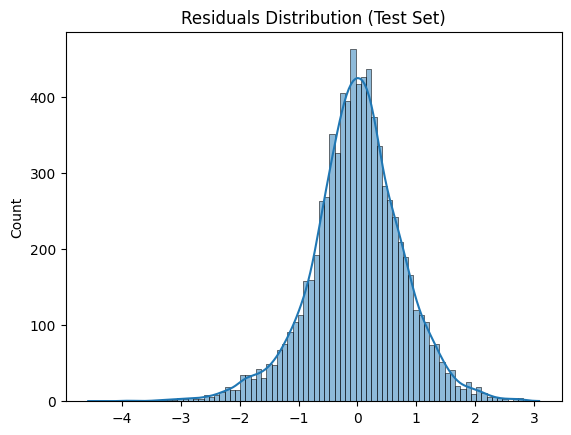

In [88]:
residuals = test_data['critics_vote'] - y_test_pred
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution (Test Set)")
plt.show()

### Summary

Based on the forward selection and backward elimination test, the final model for GLM will be GLM 6: 'critics_vote ~ actor_avg_critics_vote + director_avg_critics_vote'.

In [89]:
print(glm_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           critics_vote   No. Observations:                31624
Model:                            GLM   Df Residuals:                    31621
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                         0.60852
Method:                          IRLS   Log-Likelihood:                -37017.
Date:                Tue, 10 Dec 2024   Deviance:                       19242.
Time:                        14:27:12   Pearson chi2:                 1.92e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9620
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             